## Image segmentation with CamVid

> ## segmentation을 해주는 이유가 무엇일까요??
    - classification의 차이는 무엇일까요?
> ## segmentation이 각 픽셀들을 처리한다면, gpu 등 컴퓨팅 자원 측면에서 어떻게 쓰는게 효과적일까요??

Image segmentation이란 이미지 속의 물체들을 의미있는 단위로 구분하는 것이다. 구체적으로는, 이미지의 각 픽셀들이 속하는 클래스를 예측하는 것이다.

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [3]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/labels'),
 PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images')]

데이터를 받아오고, 폴더를 보니 labels와 images가 있다.

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

## Subset classes

In [5]:
'''path = Path('./data/camvid-small')

def get_y_fn(x): return Path(str(x.parent)+'annot')/x.name

codes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',
     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])

src = (SegmentationItemList.from_folder(path)
        .split_by_folder(valid='val')
        .label_from_func(get_y_fn, classes=codes))

bs=8
data = (src.transform(get_transforms(), tfm_y=True)
         .databunch(bs=bs)
        .normalize(imagenet_stats))'''

"path = Path('./data/camvid-small')\n\ndef get_y_fn(x): return Path(str(x.parent)+'annot')/x.name\n\ncodes = array(['Sky', 'Building', 'Pole', 'Road', 'Sidewalk', 'Tree',\n     'Sign', 'Fence', 'Car', 'Pedestrian', 'Cyclist', 'Void'])\n\nsrc = (SegmentationItemList.from_folder(path)\n        .split_by_folder(valid='val')\n        .label_from_func(get_y_fn, classes=codes))\n\nbs=8\ndata = (src.transform(get_transforms(), tfm_y=True)\n         .databunch(bs=bs)\n        .normalize(imagenet_stats))"

## Data

In [6]:
fnames = get_image_files(path_img)
fnames[:3]

[PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f00990.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_06450.png'),
 PosixPath('/root/.fastai/data/camvid/images/0016E5_04530.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f02040_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f01290_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0001TP_010020_P.png')]

각 폴더에 다음의 이름을 가진 png파일이 있는데, 좀더 자세히 알아볼 것이다. 일단 파일명을 보니 뒤에 _P가 붙은 애들이 있어서 아마 이것이 segment masks 씌운 것같다.

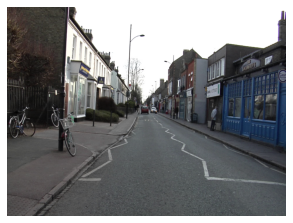

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

그래서 간단한 함수를 만들어서 위 이미지 경로/파일명에다 약간 수정을 가해서 확인해보니, 

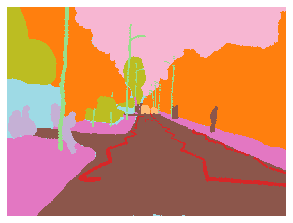

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

역시 labels폴더의 _P들이 segment였다. 참고로 이번에 우리는 실수가 아니라 정수 값을 가진 이미지들을 받고 싶기 때문에 open_image가 아닌 open_mask를 쓴다. 둘의 차이는, open_image는 Image를 리턴하고, open_mask는 ImageSegment를 리턴한다. https://docs.fast.ai/vision.image.html#open_image

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          [26, 26, 26,  ..., 21, 21, 21],
          ...,
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17],
          [19, 19, 19,  ..., 17, 17, 17]]]))

사이즈는 [720, 960]이고, 이것들은 codes.txt와 valid.txt를 줬다. 아마도 codes.txt가 가능한 label들일 것 같다.

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

역시 텍스트를 읽어보니 물체들의 종류이다.

## Datasets

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=4, have 7601MB of GPU RAM free


노트북을 쓰는 나는 bs가 4이다...

In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

마찬가지로 datablock API를 활용해 데이터셋을 만든다.

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

DataBunch가 만들어졌고, 이미지들에는 변형과 normalize가 적용되었다.

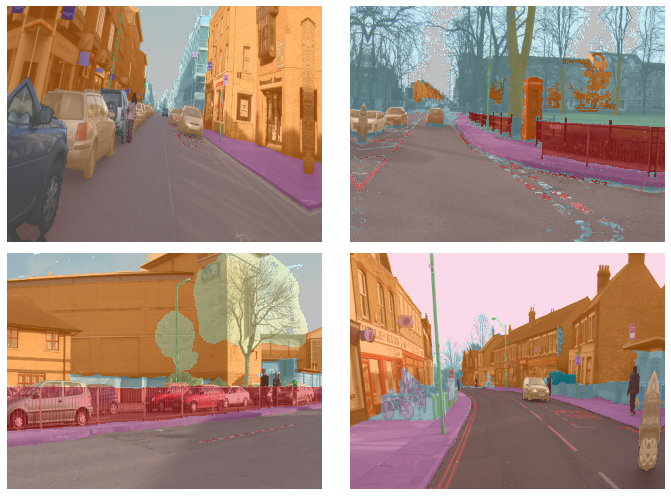

In [16]:
data.show_batch(2, figsize=(10,7))

이런식으로 의미있는 애들끼리 색이 있는 파일들이다.

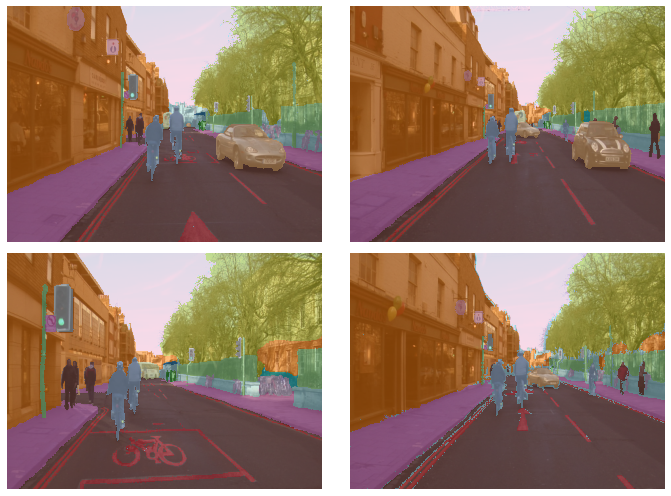

In [17]:
data.show_batch(2, figsize=(10,7), ds_type=DatasetType.Valid)

## Model

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid
# metrics=accuracy

흠, 위 두개 코드가 뭘 하는지 확실하지 않다. 강의자는 그 이유가 우리가 이미지에 라벨을 붙이면 어떤 픽셀들은 void라고 붙으며, 이 void pixels를 반드시 제거해야 하기 때문이라고 한다. 어쨌든 그래서 그런 void를 제거하는 acc_camvid로 만든 새로운 accuracy를 패스해준다.

In [0]:
wd=1e-2

In [21]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


여기서부터는 지금까지 해오던 것들이랑 같다.

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


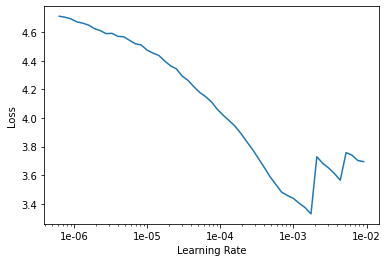

In [22]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [24]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.959731,0.691672,0.823033,01:40
1,1.224071,1.058916,0.755321,01:38
2,0.805487,0.652433,0.829434,01:38


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

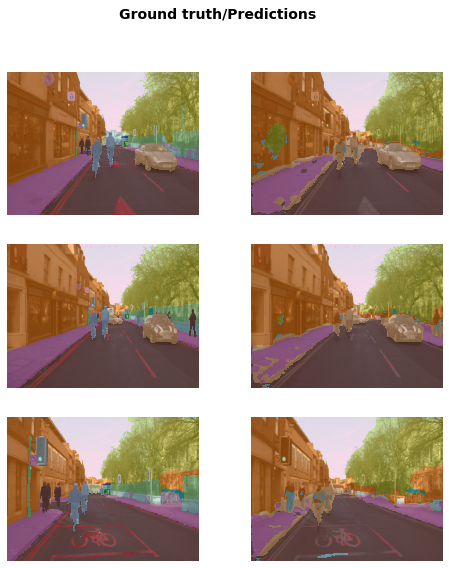

In [27]:
learn.show_results(rows=3, figsize=(8,9))

왼쪽이 실제고 오른쪽이 예측 결과인데, 거의 비슷하게 의미있는 것 끼리 구별을 해냈다.

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(lr/400,lr/4)

In [30]:
learn.fit_one_cycle(3, lrs, pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.637605,0.535965,0.856263,01:44
1,0.550470,0.517974,0.858151,01:44
2,0.483182,0.389316,0.887835,01:44


In [0]:
learn.save('stage-2');

## Go big

You may have to restart your kernel and come back to this stage if you run out of memory, and may also need to decrease `bs`.

In [32]:
learn.destroy()

size = src_size

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=3
else:           bs=1
print(f"using bs={bs}, have {free}MB of GPU RAM free")

this Learner object self-destroyed - it still exists, but no longer usable
using bs=1, have 7074MB of GPU RAM free


In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=wd)

In [0]:
learn.load('stage-2');

epoch,train_loss,valid_loss,acc_camvid,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


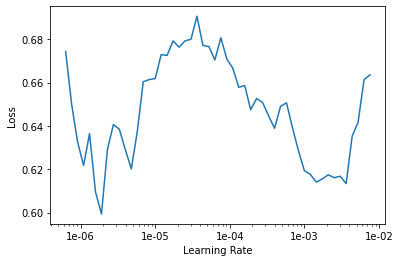

In [36]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=1e-3

In [38]:
learn.fit_one_cycle(3, slice(lr), pct_start=0.8)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.565369,0.505664,0.847475,06:51
1,0.588001,0.459507,0.882598,06:50
2,0.428632,0.333813,0.908548,06:50


In [0]:
learn.save('stage-1-big')

In [0]:
learn.load('stage-1-big');

In [0]:
learn.unfreeze()

In [0]:
lrs = slice(1e-6,lr/10)

In [43]:
learn.fit_one_cycle(3, lrs)

epoch,train_loss,valid_loss,acc_camvid,time
0,0.427792,0.350696,0.900596,07:15
1,0.382286,0.310934,0.911899,07:14
2,0.343953,0.313856,0.911239,07:15


최종 정확도는 91퍼센트 정도로 강의자에 의하면 꽤 높은 것이라고 한다.

In [0]:
learn.save('stage-2-big')

In [0]:
learn.load('stage-2-big');

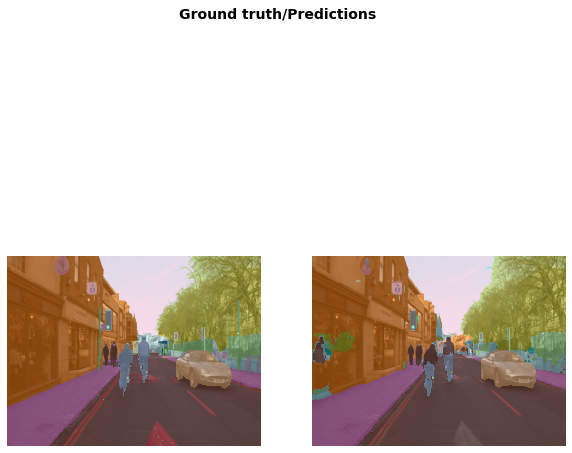

In [49]:
learn.show_results(rows=3, figsize=(10,10))

최종 결과로, 좌측 이미지와 거의 유사하게 픽셀들을 구분했다.

## fin